In [1]:
import geopandas as gpd
import pandas as pd

# Earthquake Impact on Nightlights in Myanmar

On 28th of March, 2025 there was a 7.7 magnitude earthquake that hit Myanmar and brought havoc to many communities within the country [UNOCHA Situation Report, 2025](https://reliefweb.int/report/myanmar/myanmar-earthquake-response-situation-report-no-5-4-may-2025). The World Myanmar Economists' Office would like to see if there was drastic changes in Nighttime Lights before and after the earthquake to ascertain changes in economic activity. 


## Data

This version of nighttime lights analysis was conducted using Collection-2 of NASA VIIRS Gap-Filled Lunar BRDF-Adjusted Nighttime Lights Daily product (VNP46A2). This collection was released only in October 2024 and correlation studies are yet to be done comparing the values from this collection to the older ones. 

However, given Collection-1 has been paused in 2025, this is the next best source of information from BlackMarble. 

## Methodology

Google Earth Engine was used to process the nighttime lights data at different administrative aggregations. The results are then overlayed with damage estimates provided by the team and with USGS Shakemaps. 

## Insights

In [2]:
def process_ntl(df):
    if 'system:index' in df.columns:
        df.drop(columns='system:index', inplace=True)
    if '.geo' in df.columns:
        df.drop(columns='.geo', inplace=True)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    if 'sum' in df.columns:
        df.rename(columns={'sum':'ntl_sum'}, inplace=True)
    

In [61]:
import pandas as pd
import os
import glob

# Set the path to the folder containing the data files
data_folder = '../../../data/ntl/daily/'

# Find all files containing 'admin1' (case insensitive) in their filename
admin1_files = glob.glob(os.path.join(data_folder, '*[aA]dmin1*.csv'))

# Create empty dataframe to store the combined data
ntl_adm1 = pd.DataFrame()

# Read each file and append to the combined dataframe
for file in admin1_files:
    #print(f"Reading file: {file}")
    df = pd.read_csv(file)
    process_ntl(df)
    #print(df['date'].max())
    ntl_adm1 = pd.concat([ntl_adm1, df])

# # Remove duplicate records
# ntl_adm1 = ntl_adm1.groupby(['date', 'ADM1_EN'])['ntl_sum'].max().reset_index()
# ntl_adm1 = ntl_adm1[ntl_adm1['date']<'2025-05-01']

# # # Similarly for admin2 files
# admin2_files = glob.glob(os.path.join(data_folder, '*[aA]dmin2*.csv'))
# ntl_adm2 = pd.DataFrame()
# for file in admin2_files:
#     df = pd.read_csv(file)
#     process_ntl(df)
#     ntl_adm2 = pd.concat([ntl_adm2, df])
# ntl_adm2 = ntl_adm2.groupby(['date', 'ADM1_EN', 'ADM2_EN'])['ntl_sum'].max().reset_index()
# ntl_adm2 = ntl_adm2[ntl_adm2['date']<'2025-05-01']

# # # Similarly for admin3 files
# admin3_files = glob.glob(os.path.join(data_folder, '*[aA]dmin3*.csv'))
# ntl_adm3 = pd.DataFrame()
# for file in admin3_files:
#     df = pd.read_csv(file)
#     process_ntl(df)
#     ntl_adm3 = pd.concat([ntl_adm3, df])
# # ntl_adm3 = ntl_adm3.groupby(['date','ADM3_EN'])['sum'].max().reset_index()
# # ntl_adm3 = ntl_adm3[ntl_adm3['date']<'2025-05-01']

In [62]:
import pandas as pd

# Define file paths with a pattern
file_paths = [
    '../../../data/ntl/daily/Myanmar_Admin0_Daily_Nightlights_2024-01-01_to_2025-05-12.csv',
    '../../../data/ntl/daily/Myanmar_Admin0_Daily_Nightlights_2024-03-13_to_2024-05-12.csv',
    '../../../data/ntl/daily/Myanmar_Admin0_Daily_Nightlights_2025-01-01_to_2025-02-28.csv',
    '../../../data/ntl/daily/Myanmar_Admin0_Daily_Nightlights_2025-03-01_to_2025-03-12.csv',
    '../../../data/ntl/daily/Myanmar_Admin0_Daily_Nightlights_2024-02-01_to_2024-03-12.csv'
]

# Read and process all files in one loop
dfs = []
for path in file_paths:
    df = pd.read_csv(path)
    # Standardize column names if needed
    if 'country_' in ''.join(df.columns):
        df = df.rename(columns={col: col.replace('country_', '') for col in df.columns if 'country_' in col})
    if 'sum' in df.columns:
        df.rename(columns={'sum':'ntl_sum'}, inplace=True)
    process_ntl(df)
    dfs.append(df)

# Combine all dataframes and remove duplicates
ntl_adm0 = pd.concat(dfs)#
ntl_adm0['ADM0_EN'] = ntl_adm0['ADM0_EN'].fillna('Myanmar')
#ntl_adm0 = ntl_adm0.groupby(['date', 'ADM0_EN'])['ntl_sum'].max().reset_index()
#ntl_adm0 = ntl_adm0[ntl_adm0['date']<'2025-05-01']

### Earthquake Map

In [5]:
mmr_adm0 = gpd.read_file('../../../data/boundaries/mmr_polbnda_adm0_250k_mimu_20240215.shp')
mmr_adm1 = gpd.read_file('../../../data/boundaries/mmr_polbnda_adm1_250k_mimu_20240215.shp')
mmr_adm2 = gpd.read_file('../../../data/boundaries/mmr_polbnda_adm2_250k_mimu_20240215.shp')
mmr_adm3 = gpd.read_file('../../../data/boundaries/mmr_polbnda_adm3_250k_mimu_20240215.shp')
mmr_adm4 = gpd.read_file('../../../data/boundaries/mmr_polbndp_adm4_250k_mimu_itos_20240215.shp')
mmr_adm5 = gpd.read_file('../../../data/boundaries/mmr_polbnda_adm5_250k_mimu_20240215.shp')

In [6]:
mi = gpd.read_file('../../../data/earthquake/mi.shp')

In [113]:
def plot_earthquake_map(gdf, column_to_plot, title="Earthquake Intensity Map", 
                       subtitle="Source: Myanmar Information Management Unit", 
                       cmap='viridis', figsize=(12, 10), legend_title=None,
                       legend_position='right', background_color='white',
                       title_fontsize=16, subtitle_fontsize=10):
    """
    Create a polished map visualization from a GeoDataFrame.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        The GeoDataFrame to plot
    column_to_plot : str
        The column in the GeoDataFrame to use for coloring
    title : str
        Main title for the map
    subtitle : str
        Subtitle/source information to display
    cmap : str or matplotlib colormap
        Colormap to use for the visualization
    figsize : tuple
        Figure size as (width, height) in inches
    legend_title : str or None
        Title for the legend, if None will use column_to_plot
    legend_position : str
        Position of the legend ('right', 'left', 'top', 'bottom')
    background_color : str
        Background color for the figure
    title_fontsize : int
        Font size for the main title
    subtitle_fontsize : int
        Font size for the subtitle
        
    Returns:
    --------
    fig : matplotlib figure
        The figure object for further customization if needed
    ax : matplotlib axis
        The axis object for further customization if needed
    """
    import matplotlib.pyplot as plt
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize, facecolor=background_color)
    
    # Plot the GeoDataFrame - simplified legend_kwds for compatibility
    gdf.plot(column=column_to_plot, 
             ax=ax,
             cmap=cmap,
             legend=True,
             legend_kwds={'orientation': 'vertical' if legend_position in ['right', 'left'] else 'horizontal',
                          'shrink': 0.8})
    
    # Remove frame, ticks, and labels
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Set title and subtitle with custom font sizes
    ax.set_title(title, fontsize=title_fontsize, fontweight='bold', pad=20)
    
    # Add subtitle at the bottom (not italic as requested)
    fig.text(0.1, 0.02, subtitle, ha='left', fontsize=subtitle_fontsize)
    
    # Add legend title manually
    if legend_title is None:
        legend_title = column_to_plot
        
    if hasattr(ax, 'get_legend'):
        legend = ax.get_legend()
        if legend:
            # Set the legend title manually
            legend.set_title(legend_title)
            
            # Adjust legend position
            if legend_position == 'right':
                legend.set_bbox_to_anchor((1.05, 0.5))
                legend._set_loc(2)  # center right
            elif legend_position == 'left':
                legend.set_bbox_to_anchor((-0.1, 0.5))
                legend._set_loc(6)  # center left
            elif legend_position == 'top':
                legend.set_bbox_to_anchor((0.5, 1.05))
                legend._set_loc(8)  # center top
            elif legend_position == 'bottom':
                legend.set_bbox_to_anchor((0.5, -0.1))
                legend._set_loc(7)  # center bottom
    
    plt.tight_layout()
    #plt.close(fig)

    return fig, ax


In [172]:
def create_comparison_maps(map_configs, figsize=None, output_path=None, suptitle=None):
    """
    Create side-by-side choropleth maps with flexible configuration.
    
    Parameters:
    -----------
    map_configs : list of dict
        List of dictionaries, each containing:
        - 'gdf': GeoDataFrame with data and geometry to plot
        - 'column': Column name to plot
        - 'title': Title for the map
        - 'cmap': Colormap (optional, defaults based on data)
        - 'vmin': Minimum value for colorbar (optional)
        - 'vmax': Maximum value for colorbar (optional)
        - 'center': Center value for diverging colormaps (optional)
    figsize : tuple, optional
        Figure size (width, height). If None, auto-calculated based on number of maps
    output_path : str, optional
        Path to save the figure
    suptitle : str, optional
        Super title for the entire figure
    
    Example:
    --------
    map_configs = [
        {
            'gdf': damage_gdf,  # GeoDataFrame with damage data and geometry
            'column': 'total_damage',
            'title': 'Earthquake Damage',
            'cmap': 'Reds'
        },
        {
            'gdf': ntl_change_gdf,  # GeoDataFrame with NTL change data and geometry
            'column': 'pct_change_15',
            'title': 'NTL Change (15 days)',
            'cmap': 'RdBu_r',
            'center': 0
        },
        {
            'gdf': ntl_change_gdf,
            'column': 'pct_change_30',
            'title': 'NTL Change (30 days)',
            'cmap': 'RdBu_r',
            'center': 0
        }
    ]
    """
    import geopandas as gpd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import numpy as np
    
    n_maps = len(map_configs)
    
    # Auto-calculate figure size if not provided
    if figsize is None:
        width = min(6 * n_maps, 24)  # Max width of 24 inches
        height = 8
        figsize = (width, height)
    
    # Create subplots
    fig, axes = plt.subplots(1, n_maps, figsize=figsize)
    
    # Handle case where there's only one map
    if n_maps == 1:
        axes = [axes]
    
    # Create each map
    for i, config in enumerate(map_configs):
        ax = axes[i]
        
        # Get the GeoDataFrame for this map
        gdf = config['gdf']
        
        # Get column to plot
        column = config['column']
        
        # Set up colormap and normalization
        cmap = config.get('cmap', 'viridis')
        vmin = config.get('vmin', gdf[column].min())
        vmax = config.get('vmax', gdf[column].max())
        
        # Handle diverging colormap with center value
        if 'center' in config:
            center = config['center']
            # Make symmetric around center for better visualization
            max_abs = max(abs(vmin - center), abs(vmax - center))
            vmin = center - max_abs
            vmax = center + max_abs
            norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
        else:
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
        
        # Create the plot
        gdf.plot(column=column, cmap=cmap, linewidth=0.5, 
                ax=ax, edgecolor='white', legend=True, norm=norm,
                legend_kwds={'shrink': 0.8, 'aspect': 20})
        
        # Set title
        ax.set_title(config['title'], fontsize=12, pad=10)
        
        # Remove axis ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Remove axis spines for cleaner look
        for spine in ax.spines.values():
            spine.set_visible(False)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Add super title if provided
    if suptitle:
        plt.suptitle(suptitle, fontsize=16, y=0.95)
        plt.subplots_adjust(top=0.88)
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
    
    plt.show()



In [8]:
earthquake_impacted_adm3 = mmr_adm3.sjoin(mi)

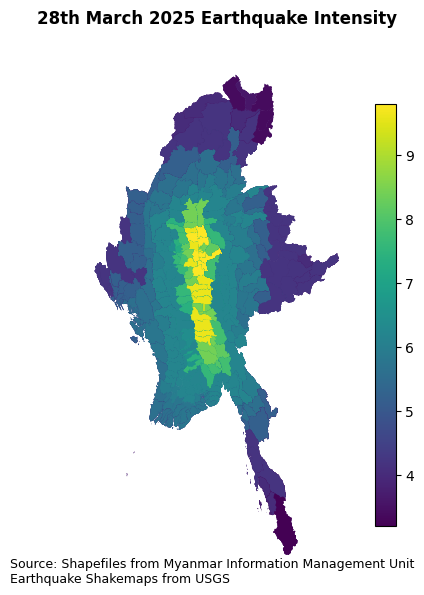

In [114]:

fig, ax = plot_earthquake_map(earthquake_impacted_adm3, 'PARAMVALUE', figsize=(5,6),
                             title="28th March 2025 Earthquake Intensity", 
                             subtitle="Source: Shapefiles from Myanmar Information Management Unit\nEarthquake Shakemaps from USGS",
                             legend_title="Intensity",
                             title_fontsize=12,
                             subtitle_fontsize=9)

In [10]:
damages = pd.read_excel('../../../data/MMR_EQ_GRADE_damage_results_Ditte_042325.xlsx')
damages = damages[~(damages['State/Region Pcode']=='TOTAL')]
damages.rename(columns={'State/Region Pcode':'ADM1_PCODE'}, inplace=True)

In [11]:
def merge_with_alt_key(df1, df2, primary_key='adm1_pcode', alt_key='adm1_altpc'):
    """
    Performs a two-step merge process:
    1. Merge df1 and df2 on primary_key
    2. For df2 rows that didn't match, try matching with df1's alt_key
    3. Concatenate both result sets
    
    Parameters:
    -----------
    df1 : DataFrame
        First dataframe with both primary_key and alt_key columns
    df2 : DataFrame
        Second dataframe with primary_key column
    primary_key : str
        Primary key column name (default: 'adm1_pcode')
    alt_key : str
        Alternative key column in df1 (default: 'adm1_altpc')
        
    Returns:
    --------
    DataFrame
        Combined results of both merge operations
    """
    import pandas as pd
    
    # Step 1: Merge df1 and df2 on primary_key
    primary_merged = df1.merge(df2, on=primary_key, how='inner')
    
    # Step 2: Find primary_key values from df2 that didn't match with df1
    df1_primary_keys = set(df1[primary_key])
    df2_primary_keys = set(df2[primary_key])
    unmatched_df2_keys = df2_primary_keys - df1_primary_keys
    
    # If all df2 rows matched on primary_key, return the first merge result
    if not unmatched_df2_keys:
        #print('returning')
        return primary_merged
    
    # Get the df2 rows that didn't match on primary_key
    unmatched_df2 = df2[df2[primary_key].isin(unmatched_df2_keys)]
    #print(unmatched_df2.shape)
    
    # Step 3: Merge unmatched df2 rows with df1 using alt_key
    alt_merged = df1.merge(
        unmatched_df2,
        left_on=alt_key,
        right_on=primary_key,
        how='inner',  # Only keep actual matches
        suffixes=('', f'_{primary_key}')
    )
    
    # If no matches on alt_key, return the primary merge result
    if alt_merged.empty:
        return primary_merged
    
    # Step 4: Concatenate both merge results
    result = pd.concat([primary_merged, alt_merged], ignore_index=True)
    
    return result

In [12]:
damages_adm1 = merge_with_alt_key(mmr_adm1[['ADM1_EN', 'ADM1_PCODE', 'ADM1_ALTPC', 'geometry']], 
            damages, 
            primary_key='ADM1_PCODE',
            alt_key='ADM1_ALTPC')

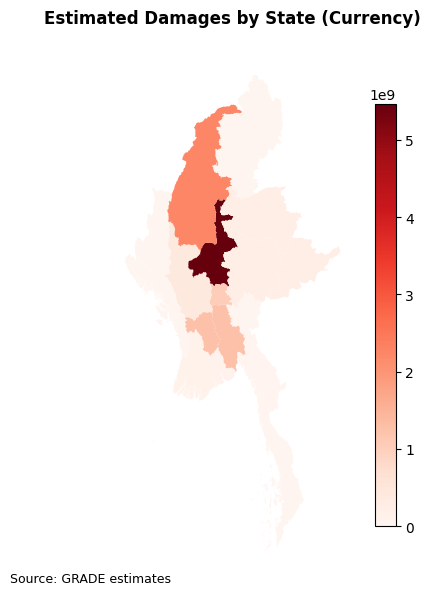

In [39]:
plot_earthquake_map(damages_adm1, 'TOTAL_DMG', 
                    title="Estimated Damages by State (Currency)", 
                    subtitle = "Source: GRADE estimates",
                    cmap='Reds',
                    title_fontsize=12,
                    subtitle_fontsize=9,
                    figsize=(5,6));

- **High Damage:** Admin 1 locations in the 90th percentile of earthquake damage and 70th percentile of impact estimates
- **Low Damage:** Admin 1 locations in the bottm 10th percentile of earthquake damage and bottom 30th percentile of impact estimates 

In [ ]:
import numpy as np
high_impact_adm1 = list(damages_adm1[damages_adm1['TOTAL_DMG']>=np.percentile(damages_adm1['TOTAL_DMG'],70)]['ADM1_EN'].unique())
high_damage_adm3 = list(earthquake_impacted_adm3[earthquake_impacted_adm3['PARAMVALUE']>=np.percentile(earthquake_impacted_adm3['PARAMVALUE'],90)]['ADM3_EN'].unique())
high_damage_adm1 = list(earthquake_impacted_adm3[earthquake_impacted_adm3['PARAMVALUE']>=np.percentile(earthquake_impacted_adm3['PARAMVALUE'],90)]['ADM1_EN'].unique())

In [24]:
import numpy as np
least_impact_adm1 = list(damages_adm1[damages_adm1['TOTAL_DMG']<=np.percentile(damages_adm1['TOTAL_DMG'],30)]['ADM1_EN'].unique())
#high_damage_adm3 = list(earthquake_impacted_adm3[earthquake_impacted_adm3['PARAMVALUE']>=np.percentile(earthquake_impacted_adm3['PARAMVALUE'],90)]['ADM3_EN'].unique())
least_damage_adm1 = list(earthquake_impacted_adm3[earthquake_impacted_adm3['PARAMVALUE']<=np.percentile(earthquake_impacted_adm3['PARAMVALUE'],10)]['ADM1_EN'].unique())

In [144]:
def plot_ntl_comparison(df, 
                        admin_region=None, 
                        earthquake_date='2025-03-28', 
                        title='NTL Sum Comparison: 2024 vs 2025 Days Overlaid',
                        output_path='../../../docs/images/ntl_comparison.png'):
    """
    Plot NTL (Night Time Lights) comparison between 2024 and 2025 for a specific administrative region.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the NTL data with 'date' and 'ntl_sum' columns.
        If admin_region is specified, should also contain a column identifying regions.
    admin_region : str, optional
        The administrative region to filter by. If None, uses all data.
    earthquake_date : str, optional
        The date of the earthquake in 'YYYY-MM-DD' format. Default is '2025-03-28'.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from datetime import datetime
    import numpy as np
    
    # Set style for prettier plots
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create a copy to avoid modifying the original DataFrame
    ntl_df = df.copy()
    
    # Convert date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(ntl_df['date']):
        ntl_df['date'] = pd.to_datetime(ntl_df['date'])
    
    # Filter by admin region if specified
    if admin_region is not None:
        # Detect the name of the admin region column (common names used)
        admin_cols = [col for col in ntl_df.columns if 'adm' in col.lower() or 'region' in col.lower() or 'province' in col.lower()]
        
        if not admin_cols:
            raise ValueError("No administrative region column found in DataFrame")
        
        # Use the first admin column found, or a specific one if you know it
        admin_col = admin_cols[0]
        ntl_df = ntl_df[ntl_df[admin_col] == admin_region]
        
        if ntl_df.empty:
            raise ValueError(f"No data found for region '{admin_region}'")
    
    # Create a day-of-year column for comparison
    ntl_df['day_of_year'] = ntl_df['date'].dt.dayofyear
    
    # Filter data for 2024 and 2025
    data_2024 = ntl_df[ntl_df['date'].dt.year == 2024]
    data_2025 = ntl_df[ntl_df['date'].dt.year == 2025]
    
    # Check if we have data for both years
    if data_2024.empty:
        print("Warning: No data available for 2024")
    if data_2025.empty:
        print("Warning: No data available for 2025")
    
    # Create figure and axis with better aesthetics
    fig, ax = plt.subplots(figsize=(14, 5))
    fig.patch.set_facecolor('white')
    
    # Define prettier colors
    color_2024 = '#2E86AB'  # Deep blue
    color_2025 = '#A23B72'  # Deep magenta/purple
    earthquake_color = '#F18F01'  # Warm orange
    
    # Plot 2024 and 2025 data by day of year with better styling
    if not data_2024.empty:
        ax.plot(data_2024['day_of_year'], data_2024['ntl_sum'], 
                label='2024', color=color_2024, linewidth=2.5, alpha=0.8)
    
    if not data_2025.empty:
        ax.plot(data_2025['day_of_year'], data_2025['ntl_sum'], 
                label='2025', color=color_2025, linewidth=2.5, alpha=0.8)
    
    # Add marker for earthquake date with enhanced styling
    earthquake_day = pd.to_datetime(earthquake_date).dayofyear
    ax.axvline(x=earthquake_day, color=earthquake_color, linestyle='--', linewidth=2, alpha=0.9)
    
    # Add a scatter point if we have data for that exact day in 2025
    if not data_2025.empty:
        earthquake_data = data_2025[data_2025['day_of_year'] == earthquake_day]
        if not earthquake_data.empty:
            ax.scatter(earthquake_day, earthquake_data['ntl_sum'].values[0], 
                      color=earthquake_color, s=150, zorder=5, marker='*',
                      edgecolors='white', linewidth=1.5)
    
    # Add text label for earthquake line
    ax.text(earthquake_day + 5, ax.get_ylim()[1] * 0.95, f'Earthquake\n{earthquake_date}', 
            color=earthquake_color, fontsize=10, fontweight='bold', 
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=earthquake_color))
    
    # Enhanced formatting
    title_text = title
    if admin_region:
        title_text += f' - {admin_region}'
    
    ax.set_title(title_text, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Month', fontsize=12, fontweight='medium')
    ax.set_ylabel('Luminosity', fontsize=12, fontweight='medium')
    
    # Prettier legend
    legend = ax.legend(loc='upper right', frameon=True, fancybox=True, 
                      shadow=True, fontsize=11)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Enhanced grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Format x-axis with month names
    month_positions = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_positions)
    ax.set_xticklabels(month_labels)
    
    # Limit x-axis to available data in 2025
    if not data_2025.empty:
        latest_day_2025 = data_2025['day_of_year'].max()
        ax.set_xlim(0, min(366, latest_day_2025 + 15))
    else:
        ax.set_xlim(0, 366)
    
    # Style the axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    
    # Format tick labels
    ax.tick_params(axis='both', which='major', labelsize=10, colors='#333333')
    
    # Add subtle background color
    ax.set_facecolor('#FAFAFA')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(output_path)
    
    return fig

# Example usage:
# fig = plot_ntl_comparison(your_dataframe, admin_region="Your Region Name")
# plt.show()

In [64]:
ntl_adm0 = ntl_adm0.sort_values(by='date')

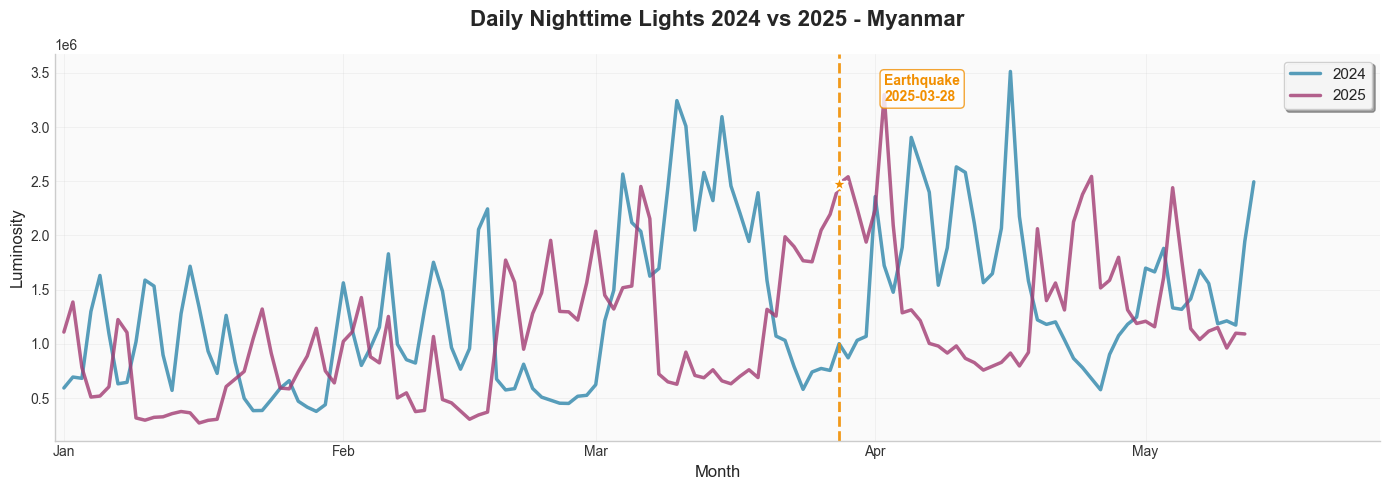

In [145]:
import matplotlib.pyplot as plt
fig = plot_ntl_comparison(ntl_adm0, 
                          admin_region='Myanmar', 
                          title='Daily Nighttime Lights 2024 vs 2025',
                          output_path='../../../docs/images/daily_ntl_comparison.png')
plt.show()

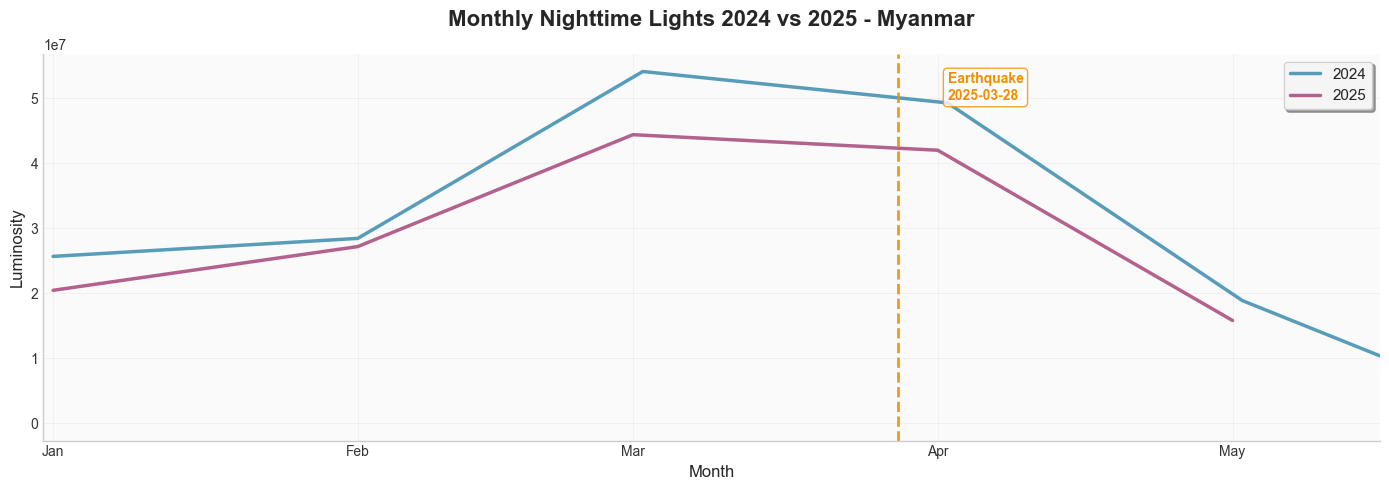

In [146]:
ntl_adm0_monthly = ntl_adm0.groupby(pd.Grouper(key='date', freq='MS'))['ntl_sum'].sum().reset_index()
ntl_adm0_monthly['ADM0_EN'] = 'Myanmar'

fig = plot_ntl_comparison(ntl_adm0_monthly, 
                    'Myanmar',
                    title='Monthly Nighttime Lights 2024 vs 2025',
                    output_path='../../../docs/images/monthly_ntl_comparison.png')



In [135]:
def plot_ntl_regions_grid(df, region_list, earthquake_date='2025-03-28', 
                          ncols=2, figsize=(16, 12), save_path=None, 
                          title='NTL Comparison by Region: 2024 vs 2025'):
    """
    Create a grid of subplots comparing NTL data for multiple regions.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the NTL data.
    region_list : list
        List of administrative regions to plot.
    earthquake_date : str, optional
        Date of the earthquake in 'YYYY-MM-DD' format.
    ncols : int, optional
        Number of columns in the grid. Default is 2.
    figsize : tuple, optional
        Figure size (width, height) in inches.
    save_path : str, optional
        Path to save the figure. If None, figure is not saved.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing all subplots.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import numpy as np
    
    # Set style for prettier plots
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Calculate number of rows needed
    nrows = (len(region_list) + ncols - 1) // ncols
    
    # Create figure and subplots with enhanced aesthetics
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.patch.set_facecolor('white')
    
    # Flatten axes array for easy iteration (even if it's a single row or column)
    if nrows == 1 and ncols == 1:
        axes = np.array([axes])
    elif nrows == 1 or ncols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Create a copy of the DataFrame to avoid modifying the original
    ntl_df = df.copy()
    
    # Convert date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(ntl_df['date']):
        ntl_df['date'] = pd.to_datetime(ntl_df['date'])
    
    # Create day-of-year column
    ntl_df['day_of_year'] = ntl_df['date'].dt.dayofyear
    
    # Determine earthquake day
    earthquake_day = pd.to_datetime(earthquake_date).dayofyear
    
    # Detect the name of the admin region column
    admin_cols = [col for col in ntl_df.columns if 'adm' in col.lower() or 'region' in col.lower() or 'province' in col.lower()]
    if not admin_cols:
        raise ValueError("No administrative region column found in DataFrame")
    admin_col = admin_cols[0]
    
    # Define prettier colors
    color_2024 = '#2E86AB'  # Deep blue
    color_2025 = '#A23B72'  # Deep magenta/purple
    earthquake_color = '#F18F01'  # Warm orange
    
    # Plot each region
    for i, region in enumerate(region_list):
        if i < len(axes):  # Make sure we don't exceed the number of subplots
            ax = axes[i]
            
            # Filter data for this region
            region_df = ntl_df[ntl_df[admin_col] == region]
            
            if region_df.empty:
                ax.text(0.5, 0.5, f"No data for {region}", ha='center', va='center',
                       fontsize=11, color='#666666', fontweight='medium')
                ax.set_title(region, fontsize=12, fontweight='bold', pad=15)
                ax.set_facecolor('#FAFAFA')
                continue
            
            # Filter data for 2024 and 2025
            data_2024 = region_df[region_df['date'].dt.year == 2024]
            data_2025 = region_df[region_df['date'].dt.year == 2025]
            
            # Plot 2024 and 2025 data by day of year with enhanced styling
            if not data_2024.empty:
                ax.plot(data_2024['day_of_year'], data_2024['ntl_sum'], 
                       label='2024', color=color_2024, linewidth=2, alpha=0.8)
            if not data_2025.empty:
                ax.plot(data_2025['day_of_year'], data_2025['ntl_sum'], 
                       label='2025', color=color_2025, linewidth=2, alpha=0.8)
            
            # Add marker for earthquake date with enhanced styling
            ax.axvline(x=earthquake_day, color=earthquake_color, linestyle='--', linewidth=1.5,
                      label='Earthquake' if i == 0 else "", alpha=0.9)
            
            # Add a scatter point if we have data for that exact day in 2025
            if not data_2025.empty:
                earthquake_data = data_2025[data_2025['day_of_year'] == earthquake_day]
                if not earthquake_data.empty:
                    ax.scatter(earthquake_day, earthquake_data['ntl_sum'].values[0], 
                              color=earthquake_color, s=80, zorder=5, marker='*',
                              edgecolors='white', linewidth=1)
            
            # Enhanced subplot styling
            ax.set_title(region, fontsize=12, fontweight='bold', pad=15)
            ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
            ax.set_axisbelow(True)
            
            # Style the axes
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_color('#CCCCCC')
            ax.spines['bottom'].set_color('#CCCCCC')
            
            # Format tick labels
            ax.tick_params(axis='both', which='major', labelsize=9, colors='#333333')
            
            # Add subtle background color
            ax.set_facecolor('#FAFAFA')
            
            # Only show legend in the first subplot to avoid repetition
            if i == 0:
                legend = ax.legend(loc='upper right', frameon=True, fancybox=True, 
                                 shadow=False, fontsize=9)
                legend.get_frame().set_facecolor('white')
                legend.get_frame().set_alpha(0.9)
            
            # Format x-axis with month names (reduced for readability in grid)
            month_positions = [1, 60, 121, 182, 244, 305]
            month_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
            ax.set_xticks(month_positions)
            ax.set_xticklabels(month_labels)
            
            # Limit x-axis to available data
            if not data_2025.empty:
                latest_day_2025 = data_2025['day_of_year'].max()
                ax.set_xlim(0, min(366, latest_day_2025 + 15))
            else:
                ax.set_xlim(0, 366)
            
            # Only add y-label to the leftmost plots
            if i % ncols == 0:
                ax.set_ylabel('Luminosity', fontsize=10, fontweight='medium')
            
            # Only add x-label to the bottom plots
            if i >= len(region_list) - ncols or i >= (nrows - 1) * ncols:
                ax.set_xlabel('Month', fontsize=10, fontweight='medium')
    
    # Hide any unused subplots
    for j in range(len(region_list), len(axes)):
        axes[j].set_visible(False)
    
    # Add overall title with enhanced styling
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.95)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.25)
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")
    
    return fig

# Example usage:
# regions = ['Region1', 'Region2', 'Region3', 'Region4']
# fig = plot_ntl_regions_grid(your_dataframe, regions)
# plt.show()

In [73]:
ntl_adm1 = ntl_adm1.sort_values(by=['ADM1_EN', 'date'])

Figure saved to ../../../docs/images/highly_impacted_admin1_ntl.png


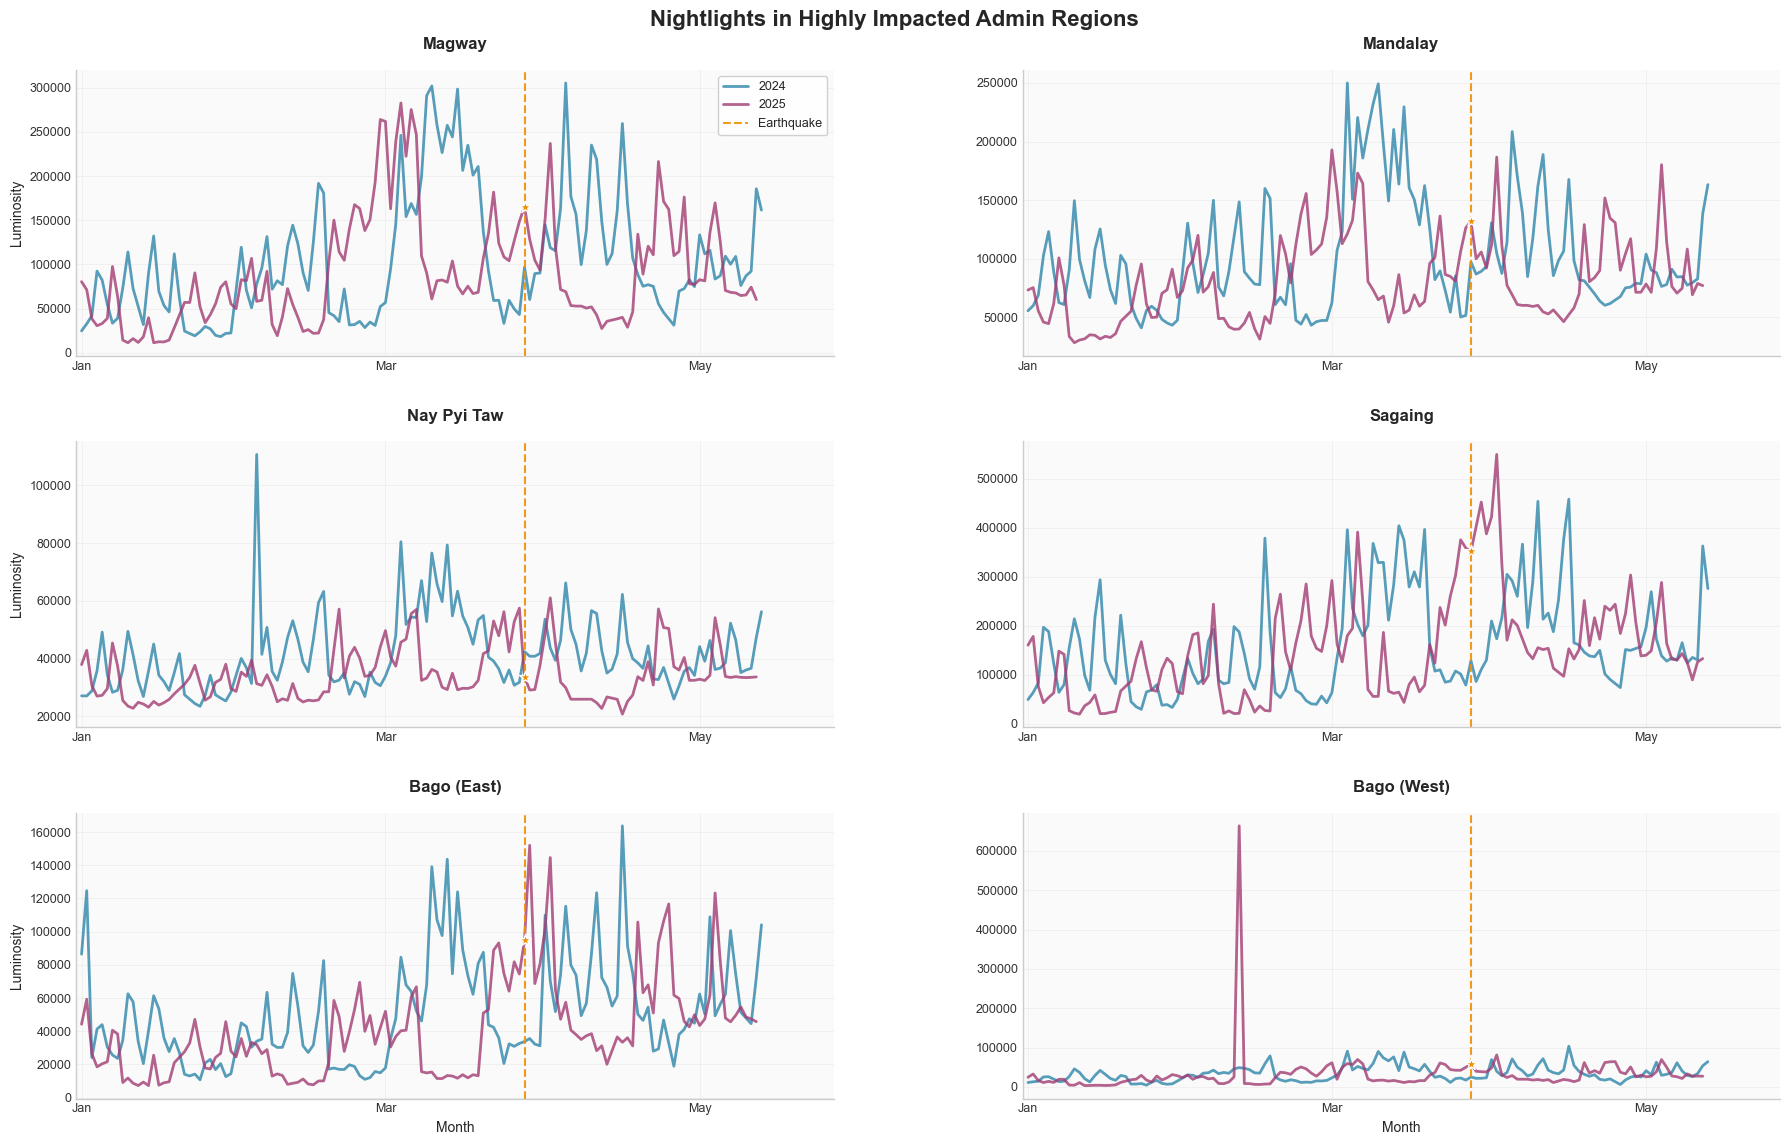

In [139]:
fig = plot_ntl_regions_grid(ntl_adm1, high_impact_adm1, ncols=2, figsize=(18, 12), 
                            save_path='../../../docs/images/highly_impacted_admin1_ntl.png', title = 'Nightlights in Highly Impacted Admin Regions');
plt.show()

Figure saved to ../../../docs/images/least_impacted_admin1_ntl.png


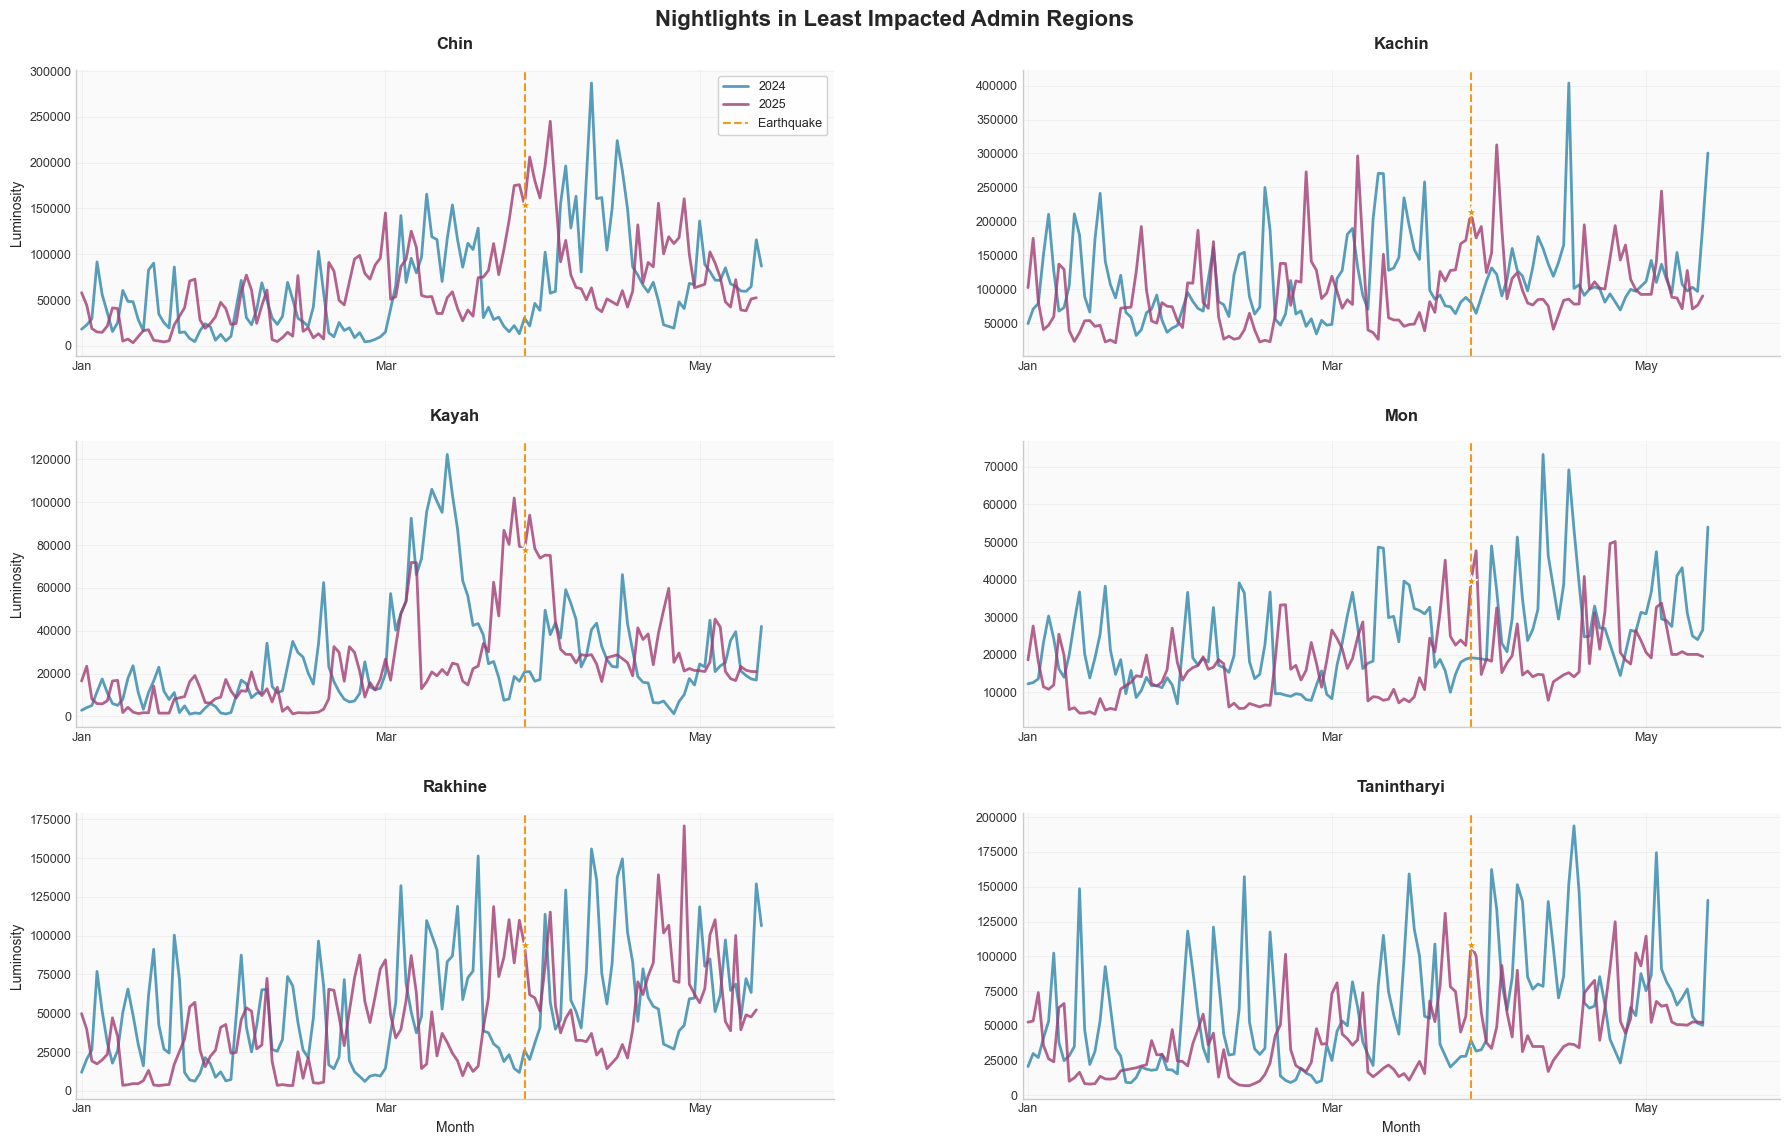

In [140]:
fig = plot_ntl_regions_grid(ntl_adm1, least_impact_adm1, ncols=2, figsize=(18, 12), 
                            save_path='../../../docs/images/least_impacted_admin1_ntl.png', title = 'Nightlights in Least Impacted Admin Regions');
plt.show()

In [155]:
def calculate_ntl_change_by_region(df, earthquake_date='2025-03-28', days_window=15, 
                                  admin_level=1, min_observations=3):
    """
    Calculate percentage change in NTL values before and after earthquake date for each admin region.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the NTL data with 'date', 'ntl_sum' columns and admin region column(s).
    earthquake_date : str, optional
        Date of the earthquake in 'YYYY-MM-DD' format. Default is '2025-03-28'.
    days_window : int, optional
        Number of days before and after the earthquake to consider. Default is 15.
    admin_level : int, optional
        Administrative level to analyze (1, 2, etc.). Default is 1.
    min_observations : int, optional
        Minimum number of observations required in each period (before/after) for a valid calculation.
        Default is 3.
    
    Returns:
    --------
    pandas DataFrame
        DataFrame with columns for admin region, before average, after average, 
        percentage change, and observation counts. All metric columns include the days_window suffix.
    """
    import pandas as pd
    import numpy as np
    
    # Create a copy of the DataFrame to avoid modifying the original
    ntl_df = df.copy()
    
    # Convert date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(ntl_df['date']):
        ntl_df['date'] = pd.to_datetime(ntl_df['date'])
    
    # Convert earthquake date to datetime
    eq_date = pd.to_datetime(earthquake_date)
    
    # Define date ranges for before and after the earthquake
    before_start = eq_date - pd.Timedelta(days=days_window)
    before_end = eq_date - pd.Timedelta(days=1)  # Day before earthquake
    after_start = eq_date  # Day of earthquake
    after_end = eq_date + pd.Timedelta(days=days_window)
    
    # Identify the admin region column based on the admin level
    admin_col = f"ADM{admin_level}_EN"
    possible_columns = [col for col in ntl_df.columns if col.lower() == admin_col.lower() or 
                       f"admin{admin_level}" in col.lower() or 
                       f"region{admin_level}" in col.lower() or 
                       f"province{admin_level}" in col.lower()]
    
    if not possible_columns:
        raise ValueError(f"No column found for administrative level {admin_level}")
    
    admin_col = possible_columns[0]
    print(f"Using column '{admin_col}' for administrative regions")
    
    # Filter data for before and after periods
    before_df = ntl_df[(ntl_df['date'] >= before_start) & (ntl_df['date'] <= before_end)]
    after_df = ntl_df[(ntl_df['date'] >= after_start) & (ntl_df['date'] <= after_end)]
    
    # Get unique admin regions
    unique_regions = ntl_df[admin_col].unique()
    
    # Prepare results DataFrame
    results = []
    
    # Calculate average NTL values for each admin region before and after
    for region in unique_regions:
        # Get data for this region
        region_before = before_df[before_df[admin_col] == region]
        region_after = after_df[after_df[admin_col] == region]
        
        # Count observations
        before_count = len(region_before)
        after_count = len(region_after)
        
        # Skip regions with insufficient data
        if before_count < min_observations or after_count < min_observations:
            continue
        
        # Calculate averages
        before_avg = region_before['ntl_sum'].mean()
        after_avg = region_after['ntl_sum'].mean()
        
        # Calculate absolute and percentage change
        abs_change = after_avg - before_avg
        
        # Handle zero or near-zero before values
        if abs(before_avg) < 1e-10:  # Avoid division by zero or very small numbers
            if abs(after_avg) < 1e-10:  # Both before and after are essentially zero
                pct_change = 0
            else:  # Before is zero, after is not
                pct_change = 100  # Represent as 100% increase
        else:
            pct_change = (abs_change / before_avg) * 100
        
        # Store results with days_window suffix on all metric columns
        results.append({
            f'ADM{admin_level}_EN': region,
            f'before_avg_{days_window}': before_avg,
            f'after_avg_{days_window}': after_avg,
            f'abs_change_{days_window}': abs_change,
            f'pct_change_{days_window}': pct_change,
            f'before_observations_{days_window}': before_count,
            f'after_observations_{days_window}': after_count
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by percentage change (largest decrease first)
    if not results_df.empty:
        results_df = results_df.sort_values(f'pct_change_{days_window}', ascending=True)
    
    return results_df

In [163]:
pc = None

for days_window in [10,15,30]:
    ntl_adm1_pc = calculate_ntl_change_by_region(ntl_adm1, admin_level=1, days_window=days_window)
    ntl_adm1_pc = mmr_adm1[['ADM1_EN', 'geometry', 'ADM1_PCODE']].merge(ntl_adm1_pc, on='ADM1_EN')
    
    if pc is None:
        pc = ntl_adm1_pc
    else:
        pc = pc.merge(ntl_adm1_pc, on=['ADM1_EN', 'geometry', 'ADM1_PCODE'])

Using column 'ADM1_EN' for administrative regions
Using column 'ADM1_EN' for administrative regions
Using column 'ADM1_EN' for administrative regions


In [ ]:
pc[['ADM1_EN', 'ADM1_PCODE', 'before_avg_10', 'after_avg_10',
       'abs_change_10', 'pct_change_10',  'before_avg_15', 'after_avg_15',
       'abs_change_15', 'pct_change_15', 'before_avg_30', 'after_avg_30',
       'abs_change_30', 'pct_change_30' ]].to_csv('../../../data/ntl/percent_change_time_periods.csv')



In [192]:
ntl_adm0[['date', 'ADM0_EN', 'ntl_sum']].to_csv('../../../data/ntl/ntl_adm0_daily.csv')
ntl_adm1[['date', 'ADM1_EN', 'ntl_sum']].to_csv('../../../data/ntl/ntl_adm1_daily.csv')


In [196]:
ntl_adm0_monthly.to_csv('../../../data/ntl/ntl_adm0_monthly.csv')

In [199]:
ntl_adm1_monthly = ntl_adm1.groupby(['ADM1_EN', pd.Grouper(key='date', freq='MS')])['ntl_sum'].sum().reset_index()
ntl_adm0_monthly.to_csv('../../../data/ntl/ntl_adm1_monthly.csv')

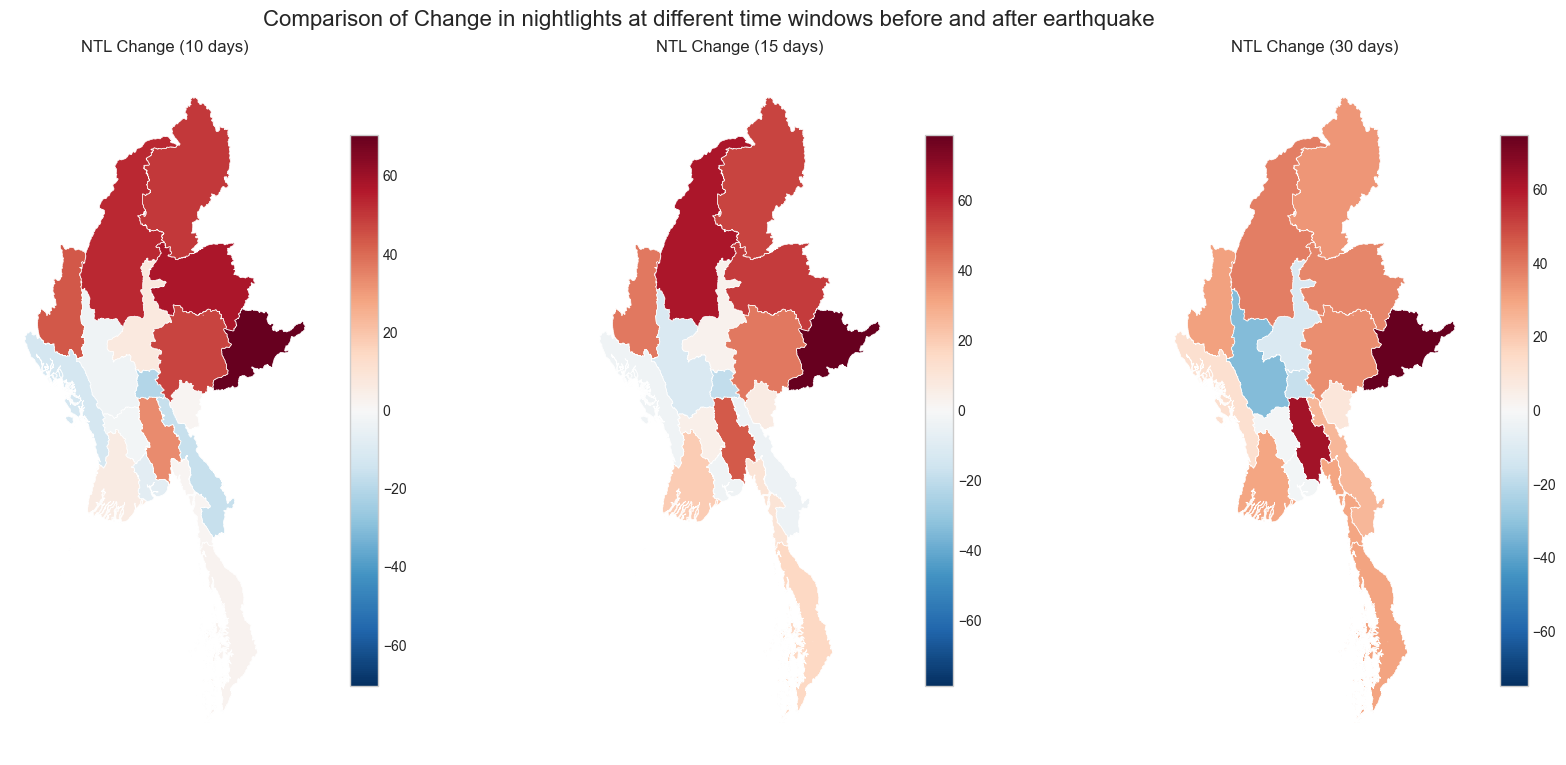

In [ ]:

map_configs_3 = [
    {
        'gdf': pc,
        'column': 'pct_change_10',
        'title': 'NTL Change (10 days)',
        'cmap': 'RdBu_r',
        'center': 0
    },
    {
        'gdf': pc,
        'column': 'pct_change_15',
        'title': 'NTL Change (15 days)',
        'cmap': 'RdBu_r',
        'center': 0
    },
    {
        'gdf': pc,
        'column': 'pct_change_30',
        'title': 'NTL Change (30 days)',
        'cmap': 'RdBu_r',
        'center': 0
    }
]

# Create the maps
create_comparison_maps(
    map_configs=map_configs_3,
    #admin_shapefile='../../../data/boundaries/mmr_polbnda_adm1_250k_mimu_20240215.shp',
    suptitle='Comparison of Change in nightlights at different time windows before and after earthquake',
    output_path='../../../docs/images/time_window_comparison_maps.png'
)

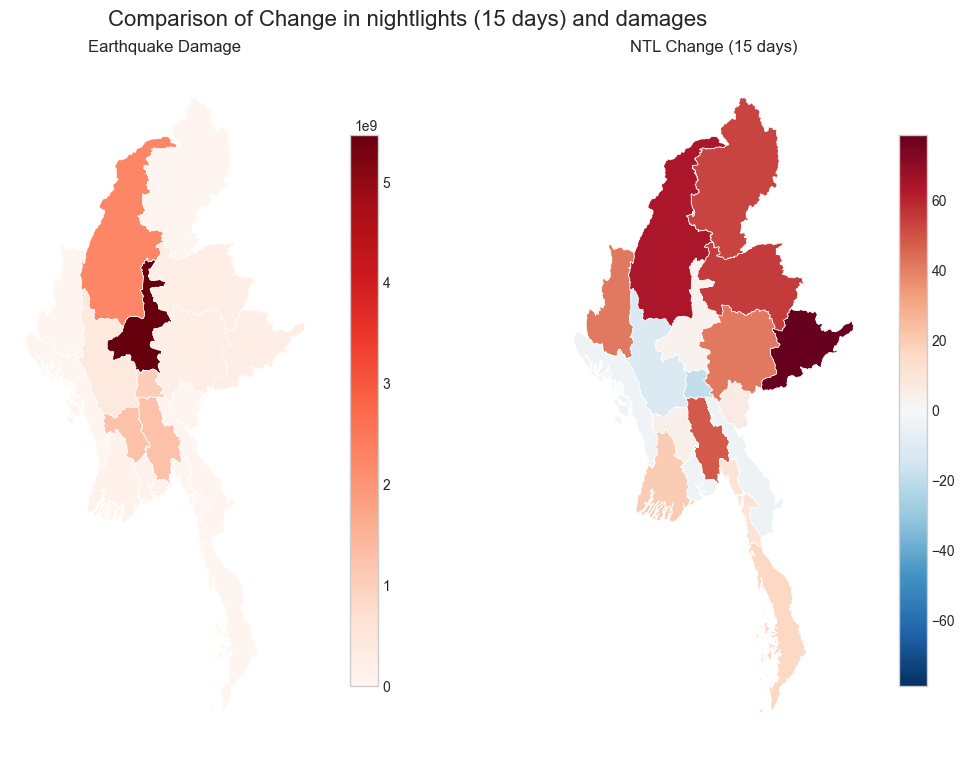

In [184]:
map_configs_2 = [
    {
        'gdf': damages_adm1,
        'column': 'TOTAL_DMG',
        'title': 'Earthquake Damage',
        'cmap': 'Reds'
    },
    {
        'gdf': pc,
        'column': 'pct_change_15',
        'title': 'NTL Change (15 days)',
        'cmap': 'RdBu_r',
        'center': 0
    }
]

create_comparison_maps(
    map_configs=map_configs_2,
    #admin_shapefile='../../../data/boundaries/mmr_polbnda_adm1_250k_mimu_20240215.shp',
    suptitle='Comparison of Change in nightlights (15 days) and damages',
    output_path='../../../docs/images/damages_ntl_comparison_maps.png'
)